In [ ]:
import os
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
batch_size = 64
train_val_split_ratio = 0.8

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                  download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=transform)

train_size = int(len(train_full_dataset)*train_val_split_ratio)
val_size = len(train_full_dataset) - train_size
train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 34.8MB/s]


In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get one batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 'images' will be a tensor of shape: [batch_size, 3, 32, 32]
# 'labels' will be a tensor of shape: [batch_size]

print(images.shape)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

torch.Size([64, 3, 32, 32])
bird  deer  dog   bird  truck frog  ship  deer  bird  plane horse ship  horse deer  deer  horse plane car   horse car   cat   frog  car   truck frog  dog   deer  plane deer  horse truck frog  deer  car   bird  deer  horse dog   truck bird  bird  plane dog   dog   car   deer  frog  car   dog   bird  dog   cat   ship  horse deer  truck ship  horse truck dog   dog   dog   dog   ship 


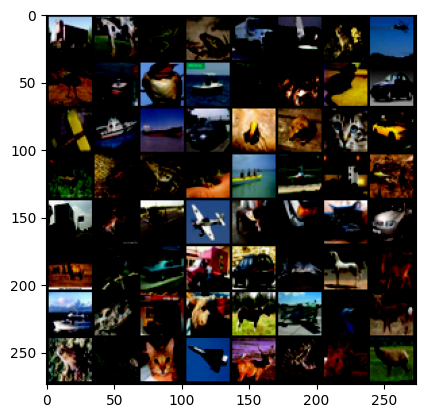

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
   npimg = img.numpy()
   plt.imshow(np.transpose(npimg, (1, 2, 0)))
   plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
labels
# show images
imshow(torchvision.utils.make_grid(images))

In [3]:
train_size = int(len(train_full_dataset)*train_val_split_ratio)
val_size = len(train_full_dataset) - train_size
train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
learning_rate = 0.001
early_stopping_patience = 5

class SimpleCNN_Baseline(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN_Baseline, self).__init__()

        # Block 1: 32x32 input -> 16x16 output
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2: 16x16 input -> 8x8 output
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 3: 8x8 input -> 4x4 output
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier (Fully Connected Layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Input calculation: 256 channels * 4 * 4 spatial dimension = 4096
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [26]:
# --- HELPER FUNCTIONS ---

def train_one_epoch(model, loader, criterion, optimizer, device):
    """Handles the training loop for a single epoch."""
    model.train()
    running_loss = 0.0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    """Handles evaluation (used for both Validation and Testing)."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / len(loader.dataset)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

model = SimpleCNN_Baseline().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 25
early_stopping_patience = 5
best_model_path = 'best_model.pth'
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []

print(f"Starting training for {epochs} epochs...")

for epoch in range(epochs):

    # 1. Run Training Step
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # 2. Run Validation Step
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # 3. Check Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1

    if epochs_no_improve == early_stopping_patience:
        print("Early stopping triggered!")
        break

# --- FINAL TESTING ---

print("Training complete. Loading best model for testing...")
model.load_state_dict(torch.load(best_model_path))

# Reuse the evaluate function for testing
_, test_accuracy = evaluate(model, test_loader, criterion, device)

print(f"Test Accuracy for the SimpleCNN (Baseline Model): {test_accuracy:.2f}%")

Starting training for 25 epochs...
Epoch [1/25] | Train Loss: 1.6896 | Val Loss: 1.4119 | Val Acc: 49.75%
Epoch [2/25] | Train Loss: 1.1259 | Val Loss: 1.0344 | Val Acc: 63.49%
Epoch [3/25] | Train Loss: 0.8524 | Val Loss: 0.8539 | Val Acc: 70.07%
Epoch [4/25] | Train Loss: 0.6744 | Val Loss: 0.7795 | Val Acc: 73.71%
Epoch [5/25] | Train Loss: 0.5445 | Val Loss: 0.7762 | Val Acc: 74.06%
Epoch [6/25] | Train Loss: 0.4309 | Val Loss: 0.7598 | Val Acc: 76.04%
Epoch [7/25] | Train Loss: 0.3248 | Val Loss: 0.8272 | Val Acc: 76.50%
Epoch [8/25] | Train Loss: 0.2376 | Val Loss: 0.9218 | Val Acc: 75.67%
Epoch [9/25] | Train Loss: 0.1934 | Val Loss: 0.9840 | Val Acc: 75.96%
Epoch [10/25] | Train Loss: 0.1588 | Val Loss: 1.0687 | Val Acc: 75.96%
Epoch [11/25] | Train Loss: 0.1513 | Val Loss: 1.0781 | Val Acc: 75.52%
Early stopping triggered!
Training complete. Loading best model for testing...
Test Accuracy for the SimpleCNN (Baseline Model): 76.24%


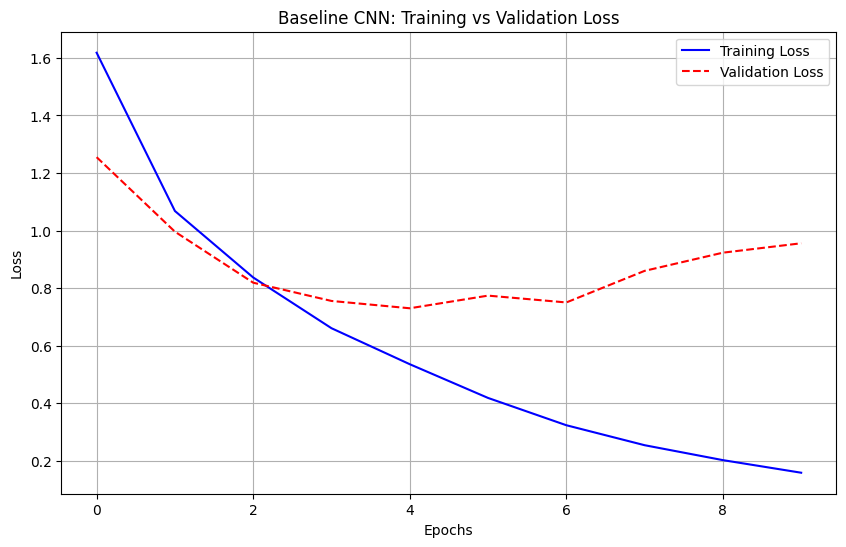

In [ ]:
import matplotlib.pyplot as plt

def plot_convergence(train_losses, val_losses, title="Model Convergence"):
    plt.figure(figsize=(10, 6))

    # Plot Training Loss
    plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-')

    # Plot Validation Loss
    plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this function after training is complete
# Assuming you stored your losses in lists named 'train_losses' and 'val_losses'
plot_convergence(train_losses, val_losses, title="Baseline CNN: Training vs Validation Loss")

In [ ]:
#--- BASELINE + Dropout (No L2) ---

class SimpleVGG_Dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleVGG_Dropout, self).__init__()

        # --- Convolution Blocks (Same as Baseline) ---
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # --- Classifier with Dropout ---
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5), # <--- Dropout Added Here
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # <--- Dropout Added Here
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [ ]:
def run_training(model, optimizer, model_name="Model"):
    """
    Runs training for a FIXED number of epochs (no early stopping).
    Tracks Loss and Accuracy for plotting.
    Saves the best model state found during the run.
    """
    print(f"\n--- Starting training for: {model_name} ---")

    criterion = nn.CrossEntropyLoss()
    epochs = 25  # Fixed number of epochs

    # Track the best performance to save the best model weights
    best_val_loss = float('inf')
    best_model_path = f'best_model_{model_name}.pth'

    # Lists to store history for plotting
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # --- 1. Train ---
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # --- 2. Validate ---
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # Store history
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # --- 3. Save Best Model (Checkpointing) ---
        # We don't stop early, but we still save the best version we find.
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

    # --- 4. Final Wrap-up ---
    # Load the best weights we found (so the model returned is the optimal one)
    print(f"Training finished. Loading best weights (Loss: {best_val_loss:.4f})")
    model.load_state_dict(torch.load(best_model_path))

    return val_losses, val_accuracies

# ==========================================
# 2. Run the 3 Experiments
# ==========================================

# --- A: Baseline ---
model_baseline = SimpleCNN_Baseline(num_classes=10).to(device)
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=0.001)
loss_base, acc_base = run_training(model_baseline, optimizer_baseline, "Baseline")

# --- B: L2 Regularization ---
model_l2 = SimpleCNN_Baseline(num_classes=10).to(device)
optimizer_l2 = torch.optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=1e-4)
loss_l2, acc_l2 = run_training(model_l2, optimizer_l2, "L2_Regularization")

# --- C: Dropout ---
model_dropout = SimpleVGG_Dropout(num_classes=10).to(device)
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.001)
loss_dropout, acc_dropout = run_training(model_dropout, optimizer_dropout, "Dropout")


--- Starting training for: Baseline ---
Epoch [1/25] | Val Loss: 1.3653 | Val Acc: 50.76%
Epoch [2/25] | Val Loss: 0.9993 | Val Acc: 64.10%
Epoch [3/25] | Val Loss: 0.9783 | Val Acc: 67.10%
Epoch [4/25] | Val Loss: 0.8006 | Val Acc: 72.83%
Epoch [5/25] | Val Loss: 0.7349 | Val Acc: 75.13%
Epoch [6/25] | Val Loss: 0.7190 | Val Acc: 76.08%
Epoch [7/25] | Val Loss: 0.8654 | Val Acc: 74.75%
Epoch [8/25] | Val Loss: 0.9356 | Val Acc: 74.14%
Epoch [9/25] | Val Loss: 0.9967 | Val Acc: 75.00%
Epoch [10/25] | Val Loss: 1.0326 | Val Acc: 75.05%
Epoch [11/25] | Val Loss: 1.1260 | Val Acc: 76.01%
Epoch [12/25] | Val Loss: 1.2144 | Val Acc: 75.50%
Epoch [13/25] | Val Loss: 1.3334 | Val Acc: 75.13%
Epoch [14/25] | Val Loss: 1.2502 | Val Acc: 75.97%
Epoch [15/25] | Val Loss: 1.3315 | Val Acc: 75.36%
Epoch [16/25] | Val Loss: 1.3093 | Val Acc: 75.55%
Epoch [17/25] | Val Loss: 1.3244 | Val Acc: 75.43%
Epoch [18/25] | Val Loss: 1.4033 | Val Acc: 75.67%
Epoch [19/25] | Val Loss: 1.3229 | Val Acc: 74.94%

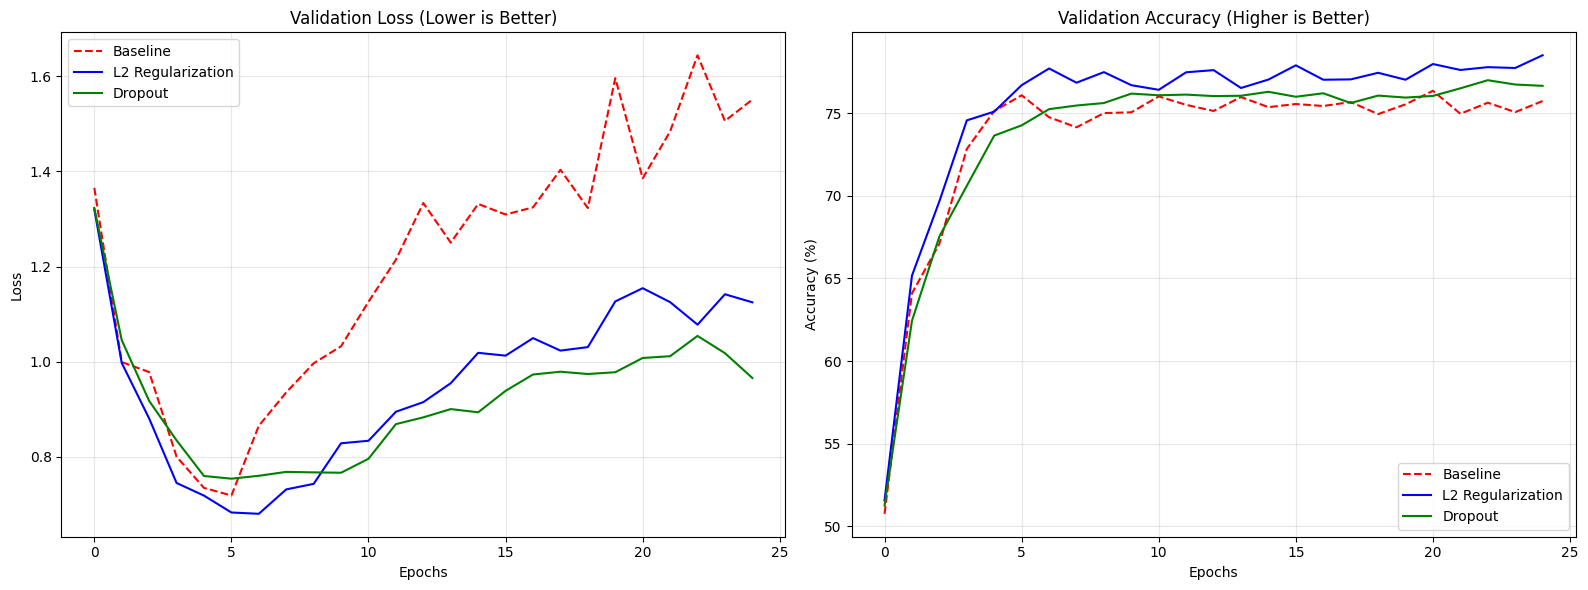

In [ ]:
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Validation Loss (Lower is Better) ---
ax1.plot(loss_base, label='Baseline', color='red', linestyle='--')
ax1.plot(loss_l2, label='L2 Regularization', color='blue')
ax1.plot(loss_dropout, label='Dropout', color='green')
ax1.set_title('Validation Loss (Lower is Better)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot 2: Validation Accuracy (Higher is Better) ---
ax2.plot(acc_base, label='Baseline', color='red', linestyle='--')
ax2.plot(acc_l2, label='L2 Regularization', color='blue')
ax2.plot(acc_dropout, label='Dropout', color='green')
ax2.set_title('Validation Accuracy (Higher is Better)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("task2_comparison_metrics.png")
plt.show()

In [ ]:
class SimpleVGG_BN_Dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleVGG_BN_Dropout, self).__init__()

        # --- Block 1 ---
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),   # <--- BN Added
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),   # <--- BN Added
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # --- Block 2 ---
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # <--- BN Added
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # <--- BN Added
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # --- Block 3 ---
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # <--- BN Added
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),  # <--- BN Added
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # --- Classifier (Same as your Dropout model) ---
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [ ]:
# --- 1. Train Model WITHOUT Batch Norm (The one you provided) ---
print("\n=== Training Model WITHOUT Batch Norm ===")
model_no_bn = SimpleVGG_Dropout(num_classes=10).to(device)
optimizer_no_bn = torch.optim.Adam(model_no_bn.parameters(), lr=0.001)
# Capture loss history
val_loss_no_bn, val_acc_no_bn = run_training(model_no_bn, optimizer_no_bn, "Without_BN")

# --- 2. Train Model WITH Batch Norm (The new one) ---
print("\n=== Training Model WITH Batch Norm ===")
model_with_bn = SimpleVGG_BN_Dropout(num_classes=10).to(device)
optimizer_with_bn = torch.optim.Adam(model_with_bn.parameters(), lr=0.001)
# Capture loss history
val_loss_with_bn, val_acc_with_bn = run_training(model_with_bn, optimizer_with_bn, "With_BN")


=== Training Model WITHOUT Batch Norm ===

--- Starting training for: Without_BN ---
Epoch [1/25] | Val Loss: 1.3420 | Val Acc: 50.72%
Epoch [2/25] | Val Loss: 1.0092 | Val Acc: 64.26%
Epoch [3/25] | Val Loss: 0.8950 | Val Acc: 69.15%
Epoch [4/25] | Val Loss: 0.7845 | Val Acc: 72.64%
Epoch [5/25] | Val Loss: 0.7339 | Val Acc: 74.55%
Epoch [6/25] | Val Loss: 0.7678 | Val Acc: 74.59%
Epoch [7/25] | Val Loss: 0.7562 | Val Acc: 75.05%
Epoch [8/25] | Val Loss: 0.7410 | Val Acc: 76.62%
Epoch [9/25] | Val Loss: 0.7397 | Val Acc: 76.40%
Epoch [10/25] | Val Loss: 0.7636 | Val Acc: 76.77%
Epoch [11/25] | Val Loss: 0.7961 | Val Acc: 76.76%
Epoch [12/25] | Val Loss: 0.8352 | Val Acc: 77.26%
Epoch [13/25] | Val Loss: 0.8386 | Val Acc: 76.26%
Epoch [14/25] | Val Loss: 0.8367 | Val Acc: 77.04%
Epoch [15/25] | Val Loss: 0.8791 | Val Acc: 76.64%
Epoch [16/25] | Val Loss: 0.8795 | Val Acc: 76.57%
Epoch [17/25] | Val Loss: 0.9022 | Val Acc: 76.65%
Epoch [18/25] | Val Loss: 0.9773 | Val Acc: 77.06%
Epoch

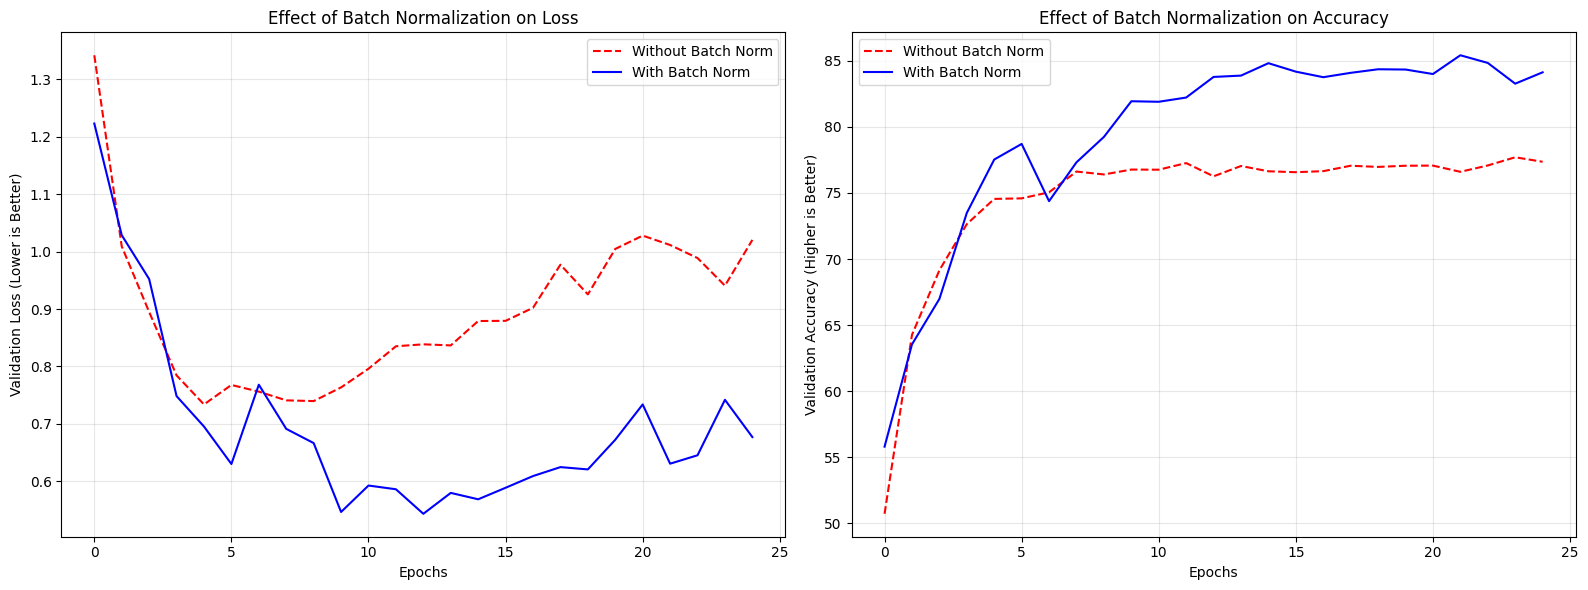

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Validation Loss Comparison ---
ax1.plot(val_loss_no_bn, label='Without Batch Norm', color='red', linestyle='--')
ax1.plot(val_loss_with_bn, label='With Batch Norm', color='blue')
ax1.set_title('Effect of Batch Normalization on Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Validation Loss (Lower is Better)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Plot 2: Validation Accuracy Comparison ---
ax2.plot(val_acc_no_bn, label='Without Batch Norm', color='red', linestyle='--')
ax2.plot(val_acc_with_bn, label='With Batch Norm', color='blue')
ax2.set_title('Effect of Batch Normalization on Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Accuracy (Higher is Better)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("batch_norm_comparison.png")
plt.show()

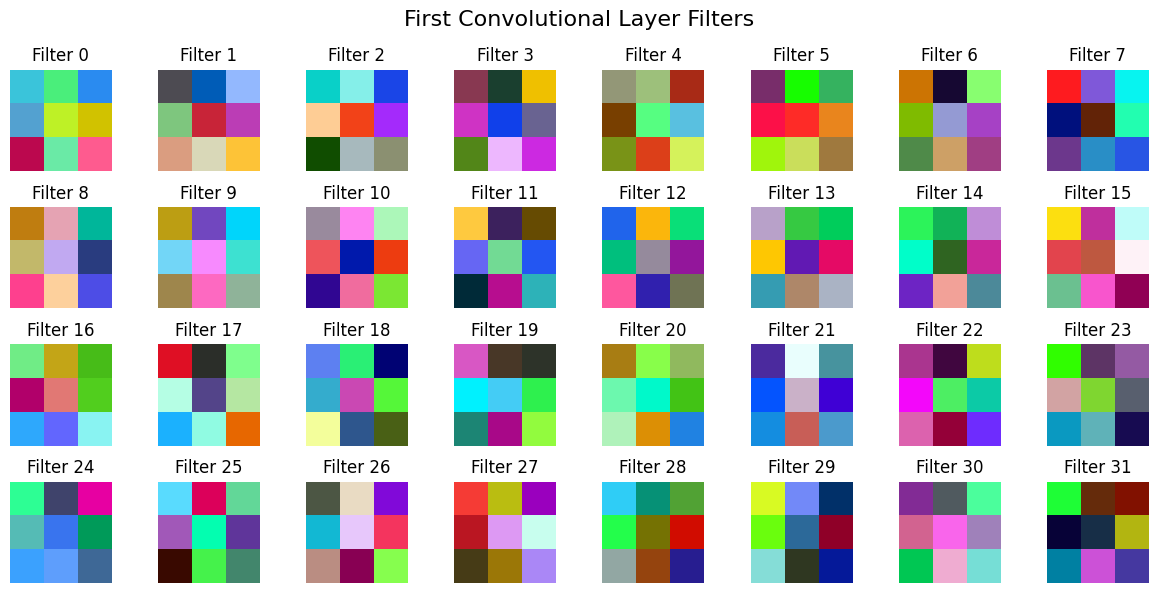

In [25]:
import matplotlib.pyplot as plt
import numpy as np

model = SimpleCNN_Baseline()

model_weights = model.block1[0].weight.data.cpu().numpy()

num_filters = model_weights.shape[0]
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
fig.suptitle('First Convolutional Layer Filters', fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < num_filters:
        f = model_weights[i, :, :, :]
        f_min, f_max = f.min(), f.max()
        f = (f - f_min) / (f_max - f_min + 1e-5)
        f = np.transpose(f, (1, 2, 0))
        ax.imshow(f)
        ax.set_title(f"Filter {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [22]:
test_iter = iter(test_loader)
images, labels = next(test_iter)
image = images[1:2].to(device)

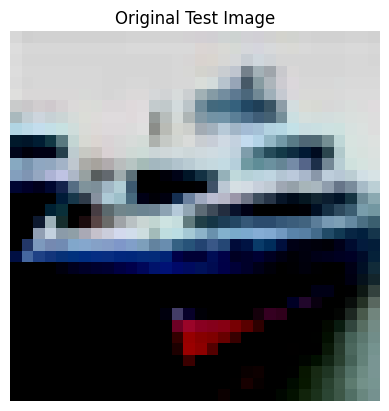

In [23]:
def display_test_image(image):
    plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
    plt.title('Original Test Image')
    plt.axis('off')
    plt.show()

test_image = display_test_image(image)

Checking input image...


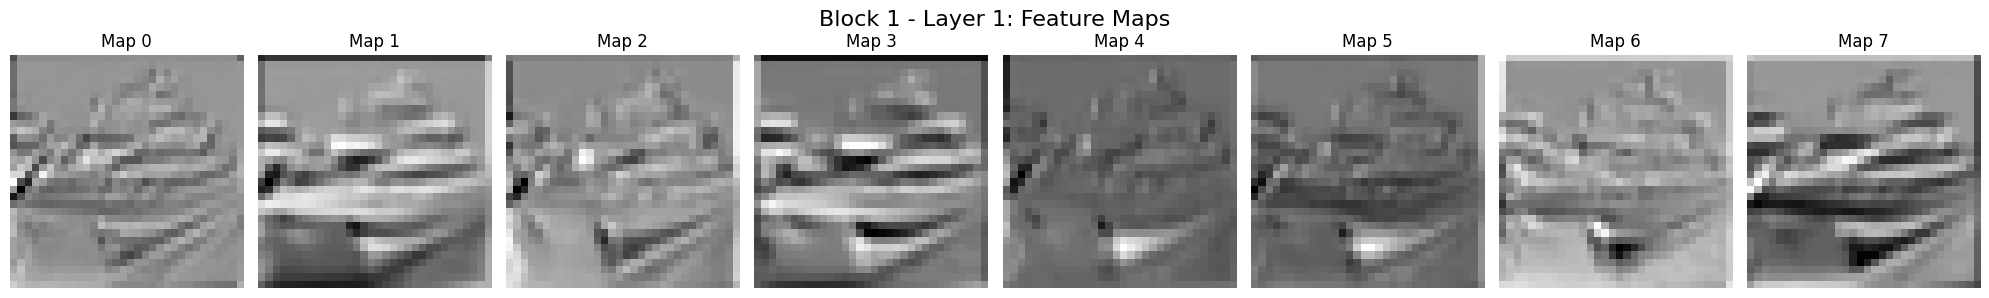

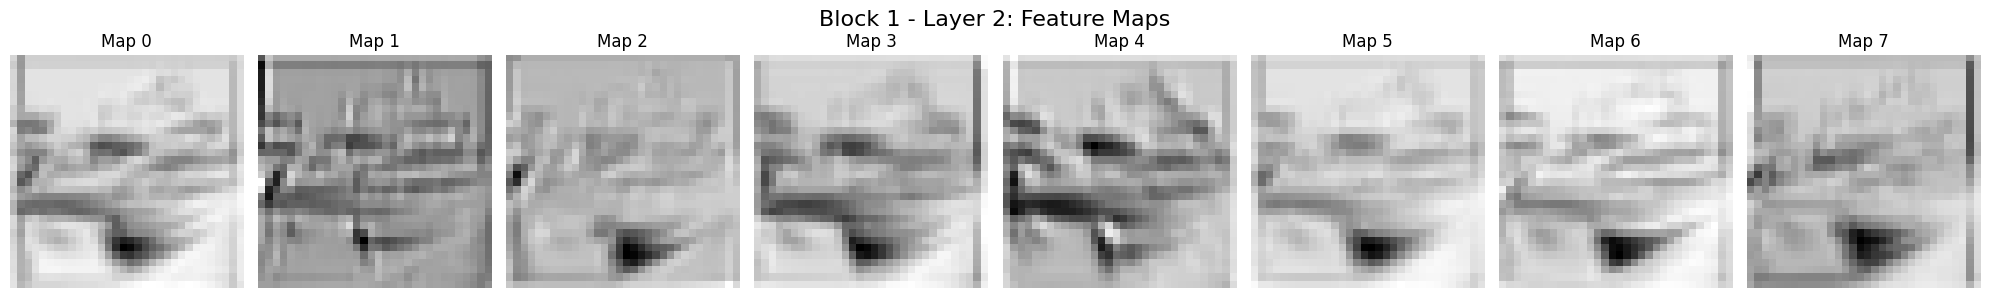

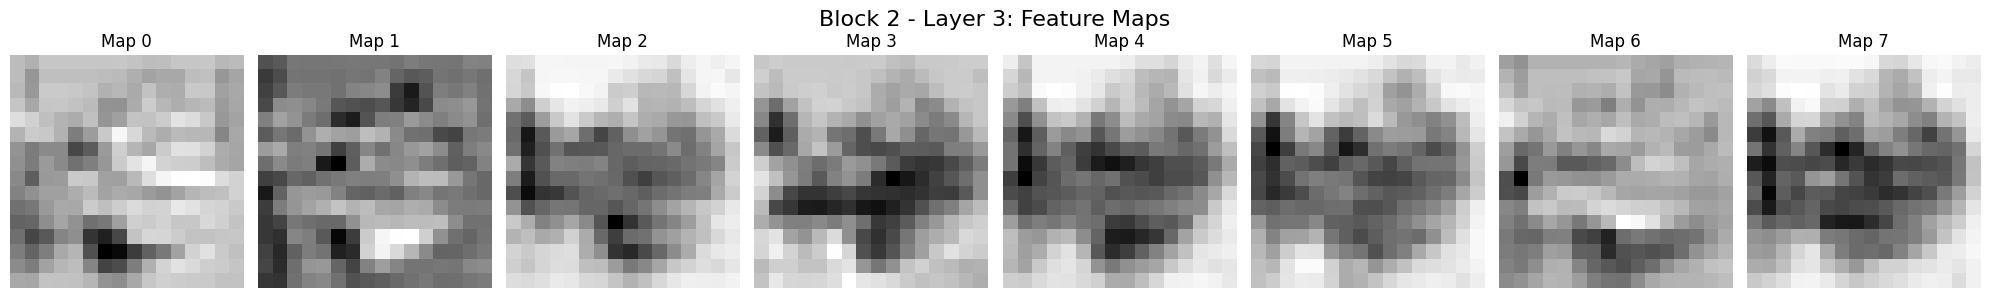

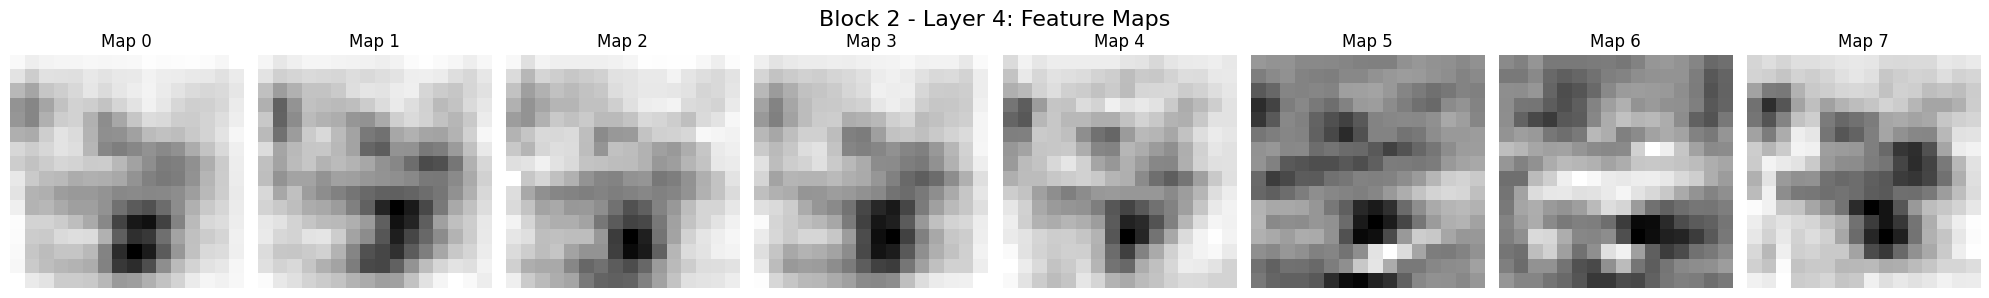

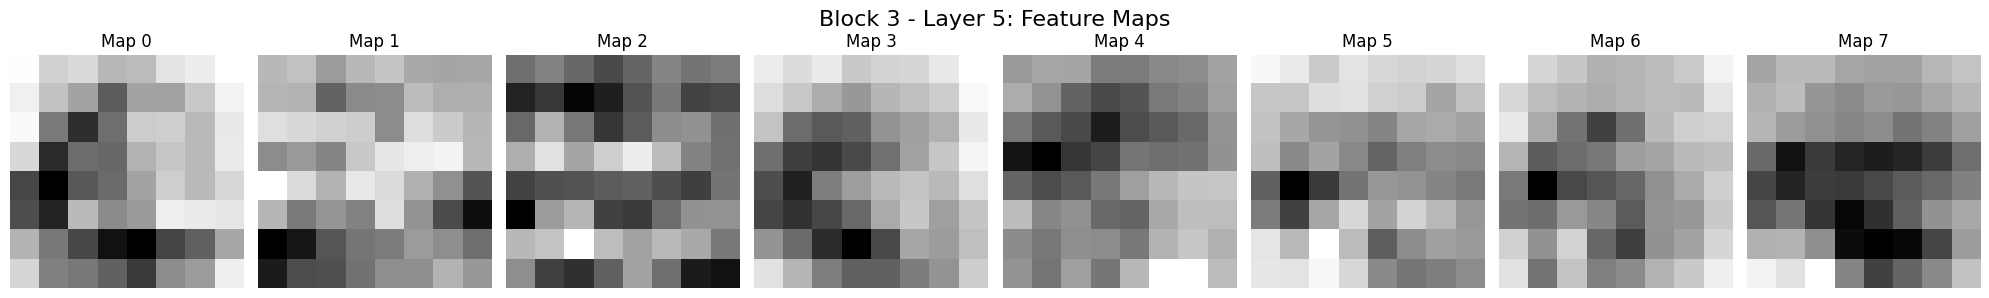

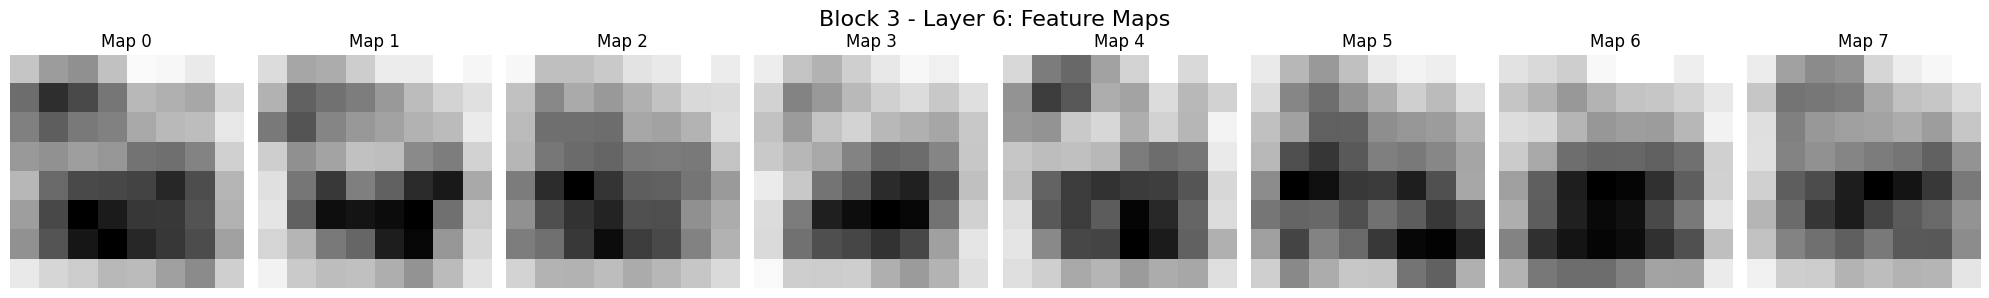

In [24]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

def visualize_feature_maps(model, image):
    model.eval()

    if len(image.shape) == 3:
        x = image.unsqueeze(0)
    else:
        x = image
    blocks = [model.block1, model.block2, model.block3]

    layer_count = 0
    for block_idx, block in enumerate(blocks):
        for layer in block:
            x = layer(x)

            if isinstance(layer, nn.Conv2d):
                layer_count += 1
                feature_maps = x.detach().cpu().numpy()[0]

                num_maps = feature_maps.shape[0]
                num_maps_to_show = min(num_maps, 8)

                fig, axes = plt.subplots(1, num_maps_to_show, figsize=(20, 3))
                fig.suptitle(f'Block {block_idx+1} - Layer {layer_count}: Feature Maps', fontsize=16)

                for i in range(num_maps_to_show):
                    fm = feature_maps[i, :, :]
                    fm_min, fm_max = fm.min(), fm.max()
                    if fm_max - fm_min > 0:
                        fm = (fm - fm_min) / (fm_max - fm_min)

                    axes[i].imshow(fm, cmap='gray')
                    axes[i].axis('off')
                    axes[i].set_title(f"Map {i}")

                plt.tight_layout()
                plt.show()

print("Checking input image...")
visualize_feature_maps(model, image.cpu())